# Intro:

## Business Problem: Predicting Water Wells In Need Of Repair For The Government Of Tanzania

## Stakeholder: The Ministry Of Water in Tanzania

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
df_train_target = pd.read_csv('./Data/training_set_labels.csv')
df_train_data = pd.read_csv('./Data/training_set_values.csv')

# Collapsing The Target Categories

The goal is to predict wells that require repair.

The target variable is `status_group` which has three categories:

- `functional`
- `functional needs repair`
- `non functional`

I will collapse the categories `functional needs repair` and `non functional` into one category `needs repair` to create a binary target variable.

In [6]:
# Look at df_train_target
df_train_target['status_group'].value_counts()



functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [7]:
# Change the name of the status_group in df_train_target 'functional needs repair' to 'repair'
# Also change the name of 'non functional' to 'repair'
df_train_target['status_group'] = df_train_target['status_group'].replace('functional needs repair', 'repair')
df_train_target['status_group'] = df_train_target['status_group'].replace('non functional', 'repair')

# Check
df_train_target['status_group'].value_counts()

functional    32259
repair        27141
Name: status_group, dtype: int64

In [8]:
# encode status_group as 0, 1
df_train_target['status_group'] = df_train_target['status_group'].astype('category')
df_train_target['status_group'] = df_train_target['status_group'].cat.codes

# Check
df_train_target['status_group'].value_counts(normalize=True)

0    0.543081
1    0.456919
Name: status_group, dtype: float64

So now I have collapsed the target categories, and I have encoded the target variable as a binary variable.

Also note that the target variable is not imbalanced.

# Chopping out columns

Okay there is way too much here. I am going to chop out some columns.

I am going to chop out the following columns:

- id
- date recorded
- funder
- installer
- wpt_name
- recorded_by
- scheme_management
- scheme_name

public_meeting
extraction type group and class?

## the data has a high degree of collinearity

I am goign to remove some columns in an attempt to fix that.

In [9]:
# show me the colinearlity of the data
df_train_data.corr()

# Drop the following columns

# 'id' - not needed
# 'recorded_by' - only one value
# 'wpt_name' - not needed
# 'num_private' - not needed
# 'subvillage' - not needed
# 'region_code' - not needed
# 'district_code' - not needed
# 'lga' - not needed
# 'ward' - not needed
# 'scheme_name' - not needed
# 'extraction_type_group' - not needed
# 'extraction_type_class' - not needed
# 'management_group' - not needed
# 'payment_type' - not needed
# 'water_quality' - not needed
# 'quantity_group' - not needed
# 'source_type' - not needed
# 'source_class' - not needed
# 'waterpoint_type_group' - not needed
# management - same as management_group
# management_group - not needed
# payment - same as payment_type
# quality_group - same as water_quality
# quantity - same as quantity_group
# date_recorded - not needed
# scheme_management - not needed
# funder - not needed
# public_meeting - not needed

df_train_data = df_train_data.drop(['id', 'recorded_by', 'wpt_name', 'num_private', 'subvillage', 'region_code', 'district_code', 'lga', 'ward', 'scheme_name', 'extraction_type_group', 'extraction_type_class', 'management_group', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group', 'management', 'payment', 'quality_group', 'quantity', 'date_recorded', 'scheme_management', 'funder', 'public_meeting'], axis=1)

In [10]:
# one hot encode the categorical data and show me the coliinearlity
# df_train_data = pd.get_dummies(df_train_data)
# df_train_data.corr()

In [11]:
# Drop id, date recorded, funder, installer, wpt_name, recorded_by, scheme_management, scheme_name, quantity_group, payment_type, extraction_type_group, extraction_type_class, management_group, public_meeting, permit, num_private
# df_train_data = df_train_data.drop(['id', 'date_recorded', 'funder', 'installer', 'wpt_name', 'recorded_by', 'scheme_management', 'scheme_name', 'quantity_group', 'payment_type', 'extraction_type_group', 'extraction_type_class', 'management_group', 'public_meeting', 'permit', 'num_private'], axis=1)

In [12]:
# remove everything but amount_tsh, gps_height, longitude, latitude, region_code, district_code, population, construction_year, lga, ward, recorded_by, scheme_management, scheme_name, management, management_group
# df_train_data = df_train_data.drop(['amount_tsh', 'wpt_name', 'id', 'date_recorded', 'num_private', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'management', 'management_group', 'public_meeting', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'payment_type', 'payment'], axis=1)

In [13]:
# check what df_train_data has now
df_train_data.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,permit,construction_year,extraction_type,source,waterpoint_type
0,6000.0,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,109,False,1999,gravity,spring,communal standpipe
1,0.0,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,280,True,2010,gravity,rainwater harvesting,communal standpipe
2,25.0,686,World vision,37.460664,-3.821329,Pangani,Manyara,250,True,2009,gravity,dam,communal standpipe multiple
3,0.0,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58,True,1986,submersible,machine dbh,communal standpipe multiple
4,0.0,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,0,True,0,gravity,rainwater harvesting,communal standpipe


In [14]:
# what are the number of columns?
len(df_train_data.columns)

13

In [15]:
# df_train_data_test = pd.get_dummies(df_train_data)
# df_train_data_test.corr()

It might actually be smarter to do this in another notebook and see if I get any improvements. 

Let this be my long notebook?

In [16]:
# # lowercase and replace spaces with underscores in all rows
# df_train_data.columns = df_train_data.columns.str.lower().str.replace(' ', '_')

# # Check
# df_train_data.head()

# # lowercase all values in df_train_data
# df_train_data = df_train_data.apply(lambda x: x.astype(str).str.lower())

# # replaces all spaces with underscores in all rows in df_train_data
# df_train_data = df_train_data.apply(lambda x: x.astype(str).str.replace(' ', '_'))

# Model with cv class

In [17]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

# Pipelines:

Time to set up some pipelines.

### Import Statements

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

### Creating The pipelines

In [19]:
subpipe_numerics = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])


# subpipe_cat = Pipeline(steps=[
#     ('cat_impute', SimpleImputer(strategy='most_frequent')),
#     ('ohe', ExtendedOneHotEncoder(sparse=False, handle_unknown='ignore'))
# ])

# extend with get_feature_names method
class ExtendedOneHotEncoder(OneHotEncoder):
    def get_feature_names(self, input_features=None):
        return self.get_feature_names(input_features=input_features)
    
subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', ExtendedOneHotEncoder(sparse=False, handle_unknown='ignore'))
])

### Creating the column transformer

In [20]:
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))
], remainder='passthrough')

### Dummy Model Pipeline:

In [21]:
dummy_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

### Logreg model pipeline

In [22]:
logreg_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('fsm', LogisticRegression(max_iter=1000))
])

### Decision Tree

In [23]:
dtc_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dtc', DecisionTreeClassifier())
])

# Test, Train, And Validation Split:

I will split the data into three sets:

- train 15%
- validation 15%
- test 70%

In [24]:
# Perform a 15-15-70 split on the data
from sklearn.model_selection import train_test_split

X = df_train_data
y = df_train_target['status_group']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)
# holdout split. I will call this validation
X_train_both, X_val, y_train_both, y_val = train_test_split(X,y,random_state=42, test_size = .1)

# Now split again to create a validation set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=77)
# Now, create my test and train splits for model creation, default test size
X_train, X_test, y_train, y_test = train_test_split(X_train_both, y_train_both, random_state=42)

# Check the shapes
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(40095, 13)
(5940, 13)
(13365, 13)


# Creating The Models

### Dummy Model:

In [25]:
# fit the dummy model
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B9D77C8A30>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

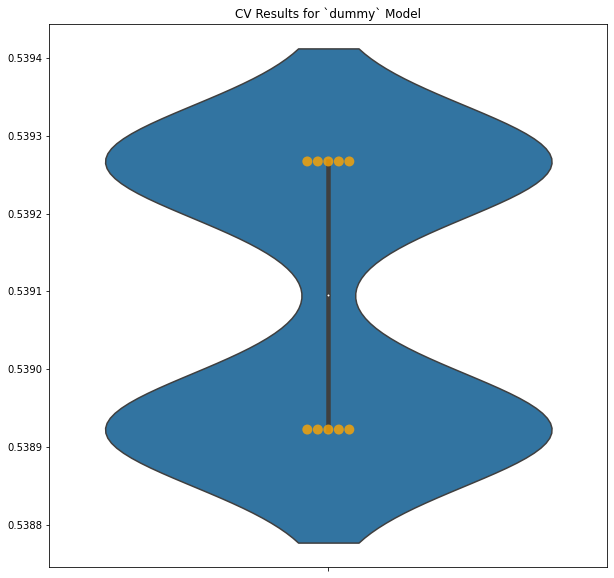

In [26]:
dummy_pipe = ModelWithCV(
    dummy_model_pipe,
    model_name='dummy',
    X=X_test,
    y=y_test)
fix, ax = plt.subplots(figsize=(10,10))

dummy_pipe.plot_cv(ax=ax)

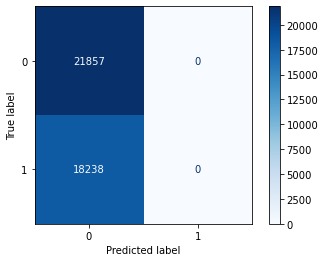

In [27]:
# confusion matrix
plot_confusion_matrix(dummy_model_pipe, X_train, y_train, cmap='Blues', values_format='d')

In [28]:
# what is the score on the test and train?
print(f'Train score: {dummy_model_pipe.score(X_train, y_train)}')
print(f'Test score: {dummy_model_pipe.score(X_test, y_test)}')

Train score: 0.5451303155006859
Test score: 0.5390946502057613


In [29]:
dummy_pipe.print_cv_summary()

CV Results for `dummy` model:
            0.53909 ± 0.00017 accuracy
        


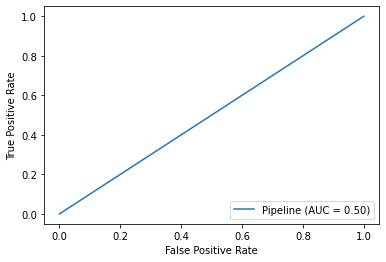

In [30]:
# plot an ROC curve
from sklearn.metrics import plot_roc_curve

plot_roc_curve(dummy_model_pipe, X_test, y_test)

### Logreg Model:

In [31]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B9D77C8A30>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

<AxesSubplot:title={'center':'CV Results for `FSM` Model'}>

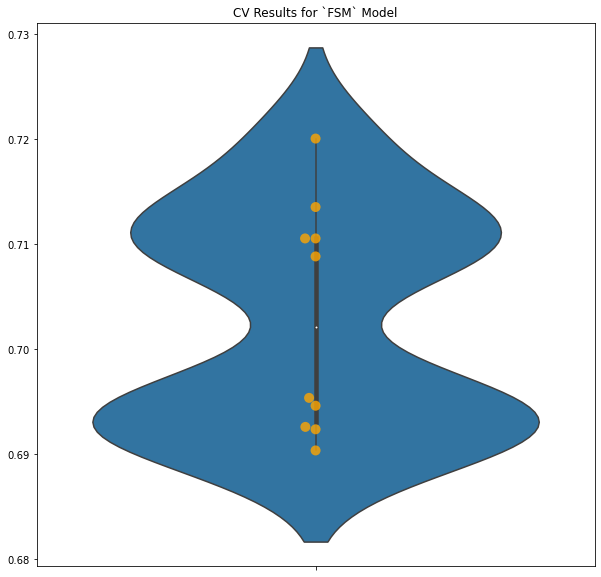

In [32]:
fsm_pipe = ModelWithCV(
    logreg_model_pipe,
    model_name='FSM',
    X=X_test,
    y=y_test)
fix, ax = plt.subplots(figsize=(10,10))

fsm_pipe.plot_cv(ax=ax)

In [33]:
# what is the score on the train and test data?
print(f'Train score: {fsm_pipe.model.score(X_train, y_train)}')
print(f'Test score: {fsm_pipe.model.score(X_test, y_test)}')

Train score: 0.7210624766180321
Test score: 0.7074448185559297


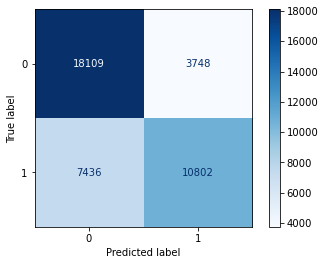

In [34]:
# Check the confusion matrix
plot_confusion_matrix(logreg_model_pipe, X_train, y_train, cmap='Blues', values_format='d')

In [35]:
fsm_pipe.print_cv_summary()

CV Results for `FSM` model:
            0.70288 ± 0.01030 accuracy
        


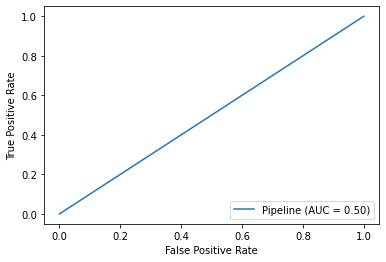

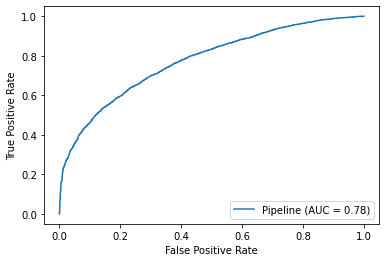

In [36]:
# plot an roc curve with the dummy and FSM
plot_roc_curve(dummy_model_pipe, X_test, y_test)
plot_roc_curve(logreg_model_pipe, X_test, y_test)

### Decision Tree Model:

In [37]:
dtc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B9D77C8A30>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

<AxesSubplot:title={'center':'CV Results for `dtc` Model'}>

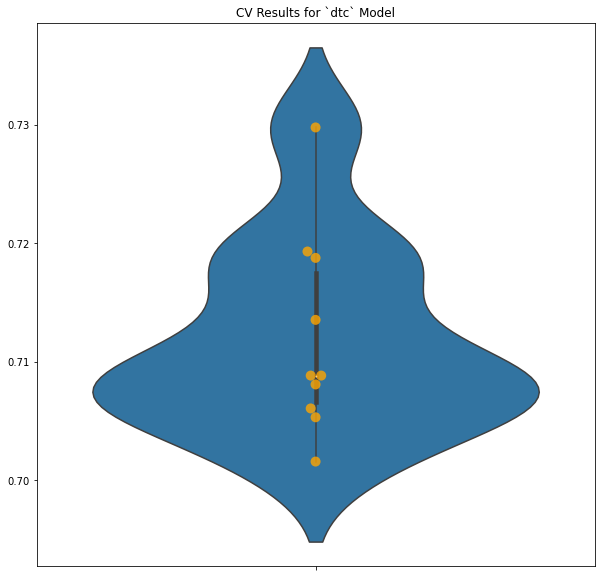

In [38]:
dtc_pipe = ModelWithCV(
    dtc_model_pipe,
    model_name='dtc',
    X=X_test,
    y=y_test)
fix, ax = plt.subplots(figsize=(10,10))

dtc_pipe.plot_cv(ax=ax)

In [39]:
# What is the score on the train and test data?
print('score on training data ', dtc_model_pipe.score(X_train, y_train))
print('score on test data ', dtc_model_pipe.score(X_test, y_test))

score on training data  0.9924429479985035
score on test data  0.7435091657313879


In [40]:
dtc_pipe.print_cv_summary()

CV Results for `dtc` model:
            0.71201 ± 0.00802 accuracy
        


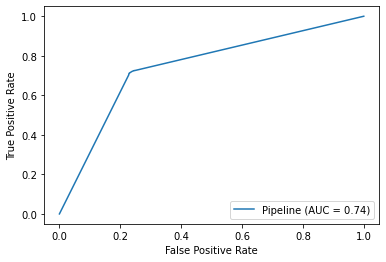

In [41]:
# plot a roc curve for the decision tree
plot_roc_curve(dtc_model_pipe, X_test, y_test)

## All models so far

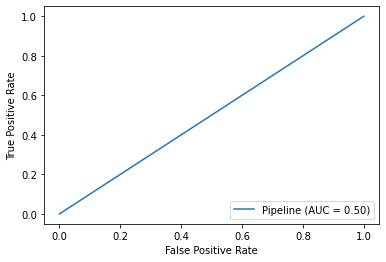

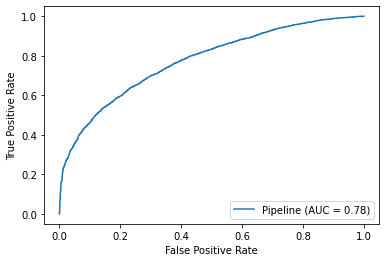

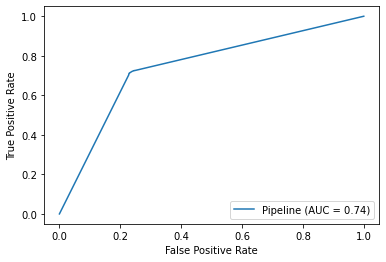

In [42]:
# plot the roc curve of the dummy, FSM, and decision tree in the same plot
plot_roc_curve(dummy_model_pipe, X_test, y_test)
plot_roc_curve(logreg_model_pipe, X_test, y_test)
plot_roc_curve(dtc_model_pipe, X_test, y_test)

# Model evaluation

## logreg

In [43]:
# # use my column transformer to transform the data
# X_train_transformed = CT.fit_transform(X_train)
# X_test_transformed = CT.transform(X_test)

# # check the shape
# print(X_train_transformed.shape)

# # get the feature importance from the decision tree
# dtc_model_pipe.named_steps['dtc'].feature_importances_

# # combine the names of the columns in X_train_transformed with the feature importance
# feature_importance = pd.DataFrame({'feature': CT.get_feature_names_out(), 'importance': dtc_model_pipe.named_steps['dtc'].feature_importances_})



## Decision Tree

# Now let's start improving the models. 

## Tuning the models with gridsearch and random gridsearch

### logreg

In [44]:
# # tune fsm_pipe with gridsearch
# from sklearn.model_selection import GridSearchCV

# # set up the gridsearch
# # make it so it won't take ages
# param_grid = {
#     'fsm__penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'fsm__C': [0.1, 1, 10, 100]
# }

# # set up the gridsearch
# gridsearch = GridSearchCV(
#     fsm_pipe.model,
#     param_grid=param_grid,
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )

# # fit the gridsearch
# gridsearch.fit(X_train, y_train)

In [45]:
# use gridsearch on the decision tree
from sklearn.model_selection import GridSearchCV
parameters = {'dtc__criterion': ['gini', 'entropy'],
          'dtc__min_samples_leaf': [10, 15, 20]}

gridsearch = GridSearchCV(
    dtc_model_pipe,
    param_grid=parameters,
    cv=5,
    verbose=2,
    n_jobs=-1
)

gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   33.5s remaining:   33.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   41.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001B9D77C8A30>),
                                                                        ('subpipe_cat',
                                                                         Pipe

In [46]:
gridsearch.best_params_

{'dtc__criterion': 'gini', 'dtc__min_samples_leaf': 10}

In [47]:
gridsearch.best_score_

0.7368749220601073

# Building The Final Model

In [48]:
final_model = gridsearch.best_estimator_

In [49]:
final_model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B9DB9C96A0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [50]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B9DB9C96A0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

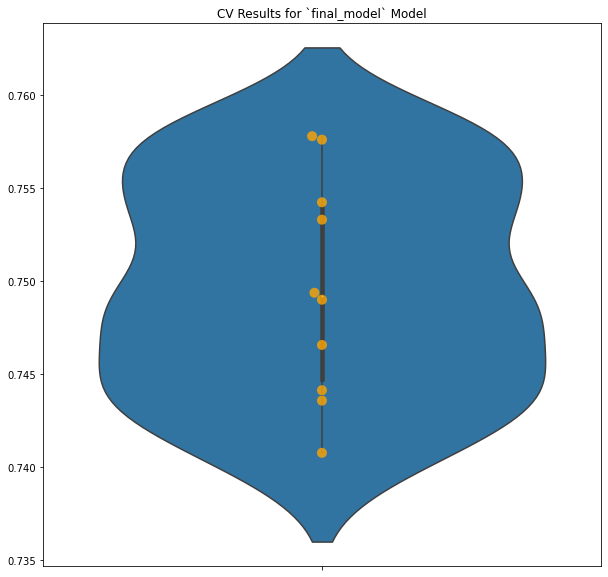

In [51]:
final_model_check = ModelWithCV(
    final_model,
    model_name='final_model',
    X=X_train_both,
    y=y_train_both)
fig, ax = plt.subplots(figsize=(10,10))

final_model_check.plot_cv(ax=ax);

In [52]:
final_model_check.print_cv_summary()

CV Results for `final_model` model:
            0.74961 ± 0.00566 accuracy
        


In [53]:
# Score against validation/hold out

final_model.score(X_val, y_val)

0.7456228956228956

In [54]:
# production model
final_model.fit(X,y)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B9DB9C96A0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [55]:
final_model.score(X,y)

0.8394276094276094

In [73]:
# get model weights
importances = final_model.named_steps['dtc'].feature_importances_
print(len(feat_imp))

# Print feature importances
# for i, importance in enumerate(importances):
#     print(f"Feature {i}: {importance}")

# Get feature names
df_train_data_temp = pd.get_dummies(df_train_data)
feature_names = df_train_data_temp.columns
#print the shape of X.columns
print(feature_names.shape)

# Get feature importances and their indices sorted in descending order
indices = np.argsort(importances)[::-1]

# Define the number of important features you want to select
N = 20

# Print the top N features
for i in range(N):
    print(f"{i+1}. {feature_names[indices[i]]} (importance: {importances[indices[i]]})")

2218
(2218,)
1. longitude (importance: 0.1890592764708226)
2. latitude (importance: 0.17041057910067609)
3. waterpoint_type_other (importance: 0.14448417588640294)
4. gps_height (importance: 0.07283817256986075)
5. construction_year (importance: 0.07102179542467278)
6. amount_tsh (importance: 0.06708811597348989)
7. waterpoint_type_communal standpipe multiple (importance: 0.04567516356929175)
8. population (importance: 0.041370589727256525)
9. region_Iringa (importance: 0.012064221330063003)
10. extraction_type_nira/tanira (importance: 0.009762483502113563)
11. extraction_type_other (importance: 0.008696278314956118)
12. source_spring (importance: 0.007954856005160138)
13. source_river (importance: 0.006973646370710915)
14. installer_DWE (importance: 0.006876168447442139)
15. installer_Government (importance: 0.006714759421829855)
16. basin_Lake Victoria (importance: 0.0057431579171243466)
17. source_rainwater harvesting (importance: 0.005454826735831297)
18. region_Arusha (importance:

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Load the iris dataset
iris = load_iris()

# Fit a DecisionTree model to the data
model = DecisionTreeClassifier(random_state=0)
model.fit(iris.data, iris.target)

# Get the feature importances
importances = model.feature_importances_

# Print feature importances
for i, importance in enumerate(importances):
    print(f"Feature {i}: {importance}")
[9:52 AM]
# Get feature names
feature_names = iris.feature_names

# Get feature importances and their indices sorted in descending order
indices = np.argsort(importances)[::-1]

# Define the number of important features you want to select
N = 2

# Print the top N features
for i in range(N):
    print(f"{i+1}. {feature_names[indices[i]]} (importance: {importances[indices[i]]})")